In [1]:
import pandas as pd
import numpy as np
from datetime import datetime, date
import matplotlib.pyplot as plt
from highlight_text import htext
from PIL import Image
import os

Useful function reset matplotlib parameters before creating a new figure

In [2]:
def reset_matplotlib():
    plt.rcParams.update(plt.rcParamsDefault)

Get back to the root of the ipl_vizs repo

In [3]:
root_path = '/'.join(os.getcwd().split('/')[:-1])

Define some key plotting parameters which we will use again and again, mainly around fonts and styling

In [4]:
title_font = 'Din Alternate'
main_font = "Gill Sans"
text_colour = 'w'
outline_colour = 'w'
background_colour =  '#96afd9'
title_font_size = 20
subtitle_font_size = 10
logo_path = root_path + '/images/logo.png'

Open team_info xls, holds lots of information like colour codes for the individual teams

We create a dictionary with keys as the team names so we can look up other features if we need them

In [5]:
team_info = pd.read_excel(root_path+ '/team_data/team_info.xlsx')
team_info = team_info.set_index('team').to_dict()

Open up all the files in the folder, i.e. all the ball by ball data we have and concat into one dataframe

In [6]:
all_data_lst = []
folder_path = root_path+'/ball_by_ball_data/ipl/'

for filename in os.listdir(folder_path):
    df = pd.read_csv(folder_path+filename)
    all_data_lst.append(df)

df = pd.concat(all_data_lst)

In [7]:
df

,match_id,year,id,over,ball,runs,extras,extra_type,batter,batter_runs,...,nonstriker_balls,nonstriker_sr,bowler,batter_out,wicket_type,team,team_code,innings_runs,innings_wickets,innings_balls
0,336040,2008,119060,19.0,6.0,2.0,0.0,NaN,S Badrinath,6,...,17,170.59,Sohail Tanvir,NaN,NaN,Chennai Super Kings,CSK,161.0,5,119.0
1,336040,2008,119050,19.0,5.0,4.0,0.0,NaN,S Badrinath,4,...,17,170.59,Sohail Tanvir,NaN,NaN,Chennai Super Kings,CSK,157.0,5,118.0
2,336040,2008,119040,19.0,4.0,1.0,0.0,NaN,MS Dhoni,29,...,0,NaN,Sohail Tanvir,NaN,NaN,Chennai Super Kings,CSK,156.0,5,117.0
3,336040,2008,119030,19.0,3.0,6.0,0.0,NaN,MS Dhoni,28,...,0,NaN,Sohail Tanvir,NaN,NaN,Chennai Super Kings,CSK,150.0,5,116.0
4,336040,2008,119020,19.0,2.0,2.0,0.0,NaN,MS Dhoni,22,...,0,NaN,Sohail Tanvir,NaN,NaN,Chennai Super Kings,CSK,148.0,5,115.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16765,501199,2011,212060,12.0,6.0,0.0,0.0,NaN,Ross Taylor,0,...,24,133.33,Dale Steyn,NaN,NaN,Rajasthan Royals,RR,83.0,2,77.0
16766,501199,2011,212050,12.0,5.0,0.0,0.0,NaN,Rahul Dravid,28,...,24,133.33,Dale Steyn,R Dravid,R Dravid b Steyn 28 (35b 2x4 0x6) SR: 80.00,Rajasthan Royals,RR,83.0,1,76.0
16767,501199,2011,212040,12.0,4.0,1.0,0.0,NaN,Johan Botha,32,...,34,82.35,Dale Steyn,NaN,NaN,Rajasthan Royals,RR,82.0,1,75.0
16768,501199,2011,212030,12.0,3.0,4.0,0.0,NaN,Johan Botha,31,...,34,82.35,Dale Steyn,NaN,NaN,Rajasthan Royals,RR,78.0,1,74.0


Brief bit of data cleaning to replace the Rising Pune Supergiant values

In [8]:
df['team'] = np.where(df['team']=='Rising Pune Supergiant', 'Rising Pune Supergiants', df['team'])

Group by match_id and batter to get the individual match performance, team will help with the colours we use in the plot.

Sum runs to get the number of runs scored in the innings

In [9]:
individual_performances = df.groupby(['batter','team','match_id','year'], as_index=False).agg({'runs':'sum'})

Sort by runs scored so we can just plot the top 10 performances

In [10]:
individual_performances.sort_values('runs', ascending=False, inplace=True)

Create a column of the team's colour so we can colour the bars accordingly

In [11]:
individual_performances['colour'] = individual_performances['team'].apply(lambda x: team_info['primary_colour'].get(x))

Create a column with a link to where the team's logo is stored, we will iterate through this in the plot

In [12]:
image_path = root_path + '/images/team_logos/ipl/'
individual_performances['image'] = individual_performances['team'].apply(lambda x: image_path + x.lower().replace(' ','_') + '.png')

Create a name column which we will use for the labels, we replace the first occurence of a space with \n to drop it onto 2 lines

In [13]:
individual_performances['name'] = individual_performances['batter'].apply(lambda x: x.replace(' ','\n',1))

Some common styling we can wrap up in a function to make it repeatable

In [14]:
def format_vt20_graphs(fig, ax):
    fig.set_facecolor(background_colour)
    ax.patch.set_facecolor(background_colour)
    plt.xticks(c=text_colour, fontfamily=main_font, fontsize=8, fontweight='bold')
    plt.yticks(c=text_colour, fontfamily=main_font, fontsize=8, fontweight='bold')
    ax.tick_params(axis='both', colors=text_colour)
    spines = ["top","right","bottom","left"]
    for s in spines:
        if s in ["top","right"]:
            ax.spines[s].set_visible(False)
        else:
            ax.spines[s].set_color(text_colour)

    return fig, ax

Function that plots the logo just below the top of the bar

In [15]:
def plot_logos(ax, t,x,i,height,max_h):
    ax.imshow(t, extent=[x+0.1, x + 0.7, i - (height+max_h/60), i-max_h/60], aspect='auto', zorder=2)
    return ax

<ipython-input-16-9c01157bdf4f>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top10['x'] = x_bar


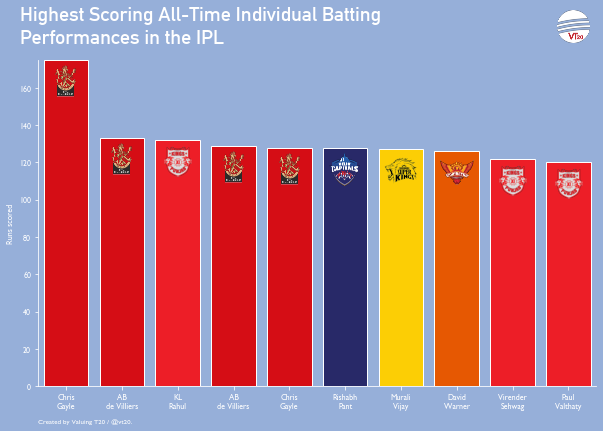

In [16]:
# Take the top 10 performances
top10 = individual_performances.head(10)

fig, ax = plt.subplots(figsize=(10,6))
fig, ax = format_vt20_graphs(fig, ax)

# We have to use range because there are duplicate names in the bar chart
# We will reassing the xticks afterwards
bars = ax.bar(range(0,10), top10['runs'], color=top10['colour'], edgecolor=text_colour)
plt.xticks(range(0,10), top10['name'])

ax.set_ylabel('Runs scored', c=text_colour, fontfamily=main_font, fontsize=8)

htext.fig_text(x = 0.1, y = 0.91,
            s = f'Highest Scoring All-Time Individual Batting\nPerformances in the IPL'
            , color = text_colour
            , fontsize=title_font_size
            , fontfamily=title_font
            , fontweight='bold')

# Get the x coordinate of each bar, used to plot the team logos
x_bar = [obj.get_x() for obj in bars]
top10['x'] = x_bar

# Maximum height
max_h = max(top10['runs'])

# Iterate through each row (i.e. each bar) and plot the team logo
for index,row in top10.iterrows():
    i = row['runs']
    height=max_h/10
    x = row['x']
    filep = row['image']
    t = Image.open(filep)
    plot_logos(ax, t,x,i,height,max_h) 

# Fix the axes
ax.set_ylim([0, max_h])
ax.set_xlim(-0.5, len(top10['name']) - 0.5) 

# Add a set of axes to plot the VT20 logo
ax2 = fig.add_axes([0.83,0.92,0.075,0.075])
ax2.axis("off")
img = Image.open(logo_path)
ax2.imshow(img)

# Putting details under the plot
fig.text(0.125, 0.04, f"Created by Valuing T20 / @vt20.",
            fontstyle="italic",fontsize=7, fontfamily=main_font, color=text_colour)

# Save image to folder
fig.savefig(root_path + '/outputs/highest_scoring_performances/all_time.jpg', facecolor=fig.get_facecolor(), dpi=500, bbox_inches = 'tight')

plt.show()

In [19]:
for year in df['year'].unique():

    # Take the top 10 performances with the additional .loc on the given year
    top10 = individual_performances.loc[individual_performances['year'] == year].head(10)

    fig, ax = plt.subplots(figsize=(10,6))
    fig, ax = format_vt20_graphs(fig, ax)

    # We have to use range because there are duplicate names in the bar chart
    # We will reassing the xticks afterwards
    bars = ax.bar(range(0,10), top10['runs'], color=top10['colour'], edgecolor=text_colour)
    plt.xticks(range(0,10), top10['name'])

    ax.set_ylabel('Runs scored', c=text_colour, fontfamily=main_font, fontsize=8)

    # Title
    htext.fig_text(x = 0.1, y = 0.91,
                s = f'Highest Scoring Individual Batting\nPerformances in the IPL {year}'
                , color = text_colour
                , fontsize=title_font_size
                , fontfamily=title_font
                , fontweight='bold')

    # Get the x coordinate of each bar, used to plot the team logos
    x_bar = [obj.get_x() for obj in bars]
    top10['x'] = x_bar

    # Maximum height
    max_h = max(top10['runs'])

    # Iterate through each row (i.e. each bar) and plot the team logo
    for index,row in top10.iterrows():
        i = row['runs']
        height=max_h/10
        x = row['x']
        filep = row['image']
        t = Image.open(filep)
        plot_logos(ax, t,x,i,height,max_h) 

    # Fix the axes
    ax.set_ylim([0, max_h])
    ax.set_xlim(-0.5, len(top10['name']) - 0.5) 

    # Add a set of axes to plot the VT20 logo
    ax2 = fig.add_axes([0.83,0.92,0.075,0.075])
    ax2.axis("off")
    img = Image.open(logo_path)
    ax2.imshow(img)

    # Putting details under the plot
    fig.text(0.125, 0.04, f"Created by Valuing T20 / @vt20.",
                fontstyle="italic",fontsize=7, fontfamily=main_font, color=text_colour)

    # Save image to folder
    fig.savefig(root_path + f'/outputs/highest_scoring_performances/{year}.jpg', facecolor=fig.get_facecolor(), dpi=500, bbox_inches = 'tight')

    # Don't want each image being displayed for every year
    plt.close(fig)

    # Let you know progress through the loop
    print(f'{year} printed')

2008 printed
2020 printed
2009 printed
2019 printed
2018 printed
2015 printed
2014 printed
2016 printed
2017 printed
2013 printed
2012 printed
2010 printed
2011 printed
